In [1]:
import warnings
warnings.filterwarnings('ignore')

from collections import defaultdict
from time import time

import numpy as np
import pandas as pd
import pandas_datareader.data as web
from logbook import Logger, StderrHandler, INFO

import matplotlib.pyplot as plt
import seaborn as sns

from zipline import run_algorithm
from zipline.api import (attach_pipeline,
                         pipeline_output,
                         date_rules,
                         time_rules,
                         record,
                         schedule_function,
                         commission,
                         slippage,
                         set_slippage,
                         set_commission,
                         order_target,
                         order_target_percent)
from zipline.data import bundles
from zipline.utils.run_algo import load_extensions
from zipline.pipeline import Pipeline, CustomFactor
from zipline.pipeline.data import Column, DataSet
from zipline.pipeline.domain import US_EQUITIES
from zipline.pipeline.filters import StaticAssets
from zipline.pipeline.loaders.frame import DataFrameLoader

import pyfolio as pf
from pyfolio.plotting import plot_rolling_returns, plot_rolling_sharpe
from pyfolio.timeseries import forecast_cone_bootstrap

sns.set_style('whitegrid')
pd.set_option('display.expand_frame_repr', False)
np.random.seed(42)

log_handler = StderrHandler(format_string='[{record.time:%Y-%m-%d %H:%M:%S.%f}]: ' +
                            '{record.level_name}: {record.func_name}: {record.message}',
                            level=INFO)
log_handler.push_application()
log = Logger('Algorithm')

N_LONGS = 20
N_SHORTS = 20
MIN_POSITIONS = 10

In [2]:
#step1: 结合bundle和其他类型数据，提取目标数
load_extensions(default=True, extensions=[], strict=True, environ=None)
bundle_data = bundles.load('quandl')

def load_predictions(bundle):
    predictions = pd.read_hdf('../00_data/backtest.h5', 'data')[['predicted']].dropna()
    tickers = predictions.index.get_level_values(0).unique().tolist()

    assets = bundle.asset_finder.lookup_symbols(tickers, as_of_date=None)
    predicted_sids = pd.Index([asset.sid for asset in assets], dtype=np.int64)
    ticker_map = dict(zip(tickers, predicted_sids))
    return (predictions
            .unstack('ticker')
            .rename(columns=ticker_map)
            .predicted), assets
            #.tz_localize(None)), assets

predictions, assets = load_predictions(bundle_data)
dates = predictions.index.get_level_values('date')
start_date = dates.min()
end_date = (dates.max() + pd.DateOffset(1))
#start = pd.Timestamp("2015-01-01")
#end = pd.Timestamp("2018-01-01")
#start = pd.Timestamp('2013-01-01', tz=UTC)
#end = pd.Timestamp('2017-01-01', tz=UTC)

In [3]:
#step2: DataFrame -> DataSet.Column -> CustomFactor -> Pipeline
class SignalData(DataSet):
    predictions = Column(dtype=float)
    domain = US_EQUITIES
    
signal_loader = {SignalData.predictions: DataFrameLoader(SignalData.predictions, predictions)}

class MLSignal(CustomFactor):
    """Converting signals to Factor so we can rank and filter in Pipeline"""
    inputs = [SignalData.predictions]
    window_length = 1

    def compute(self, today, assets, out, preds):
        out[:] = preds
        
def compute_signals():
    signals = MLSignal()
    #predictions = SignalData.predictions.latest
    return Pipeline(columns={
        'longs' : signals.top(N_LONGS, mask=signals > 0),
        'shorts': signals.bottom(N_SHORTS, mask=signals < 0)},
            screen=StaticAssets(assets)
    )

In [4]:
#step3: 注册initialize、before_trading_start、schedule_function
def rebalance(context, data):
    """
    Execute orders according to schedule_function() date & time rules.
    """
    trades = defaultdict(list)

    for stock, trade in context.trades.items():
        if not trade:
            order_target(stock, 0)
        else:
            trades[trade].append(stock)
    context.longs, context.shorts = len(trades[1]), len(trades[-1])
    if context.longs > context.min_positions and context.shorts > context.min_positions:
        for stock in trades[-1]:
            order_target_percent(stock, -1 / context.shorts)
        for stock in trades[1]:
            order_target_percent(stock, 1 / context.longs)
            
def record_vars(context, data):
    """
    Plot variables at the end of each day.
    """
    record(leverage=context.account.leverage,
           longs=context.longs,
           shorts=context.shorts)

def initialize(context):
    """
    Called once at the start of the algorithm.
    """
    context.n_longs = N_LONGS
    context.n_shorts = N_SHORTS
    context.min_positions = MIN_POSITIONS
    context.universe = assets

    set_slippage(slippage.FixedSlippage(spread=0.00))
    set_commission(commission.PerShare(cost=0, min_trade_cost=0))

    schedule_function(rebalance,
                      date_rules.every_day(),
                      time_rules.market_open(hours=1, minutes=30))

    schedule_function(record_vars,
                      date_rules.every_day(),
                      time_rules.market_close())

    pipeline = compute_signals()
    attach_pipeline(pipeline, 'signals')
    
def before_trading_start(context, data):
    """
    Called every day before market open.
    """
    output = pipeline_output('signals')
    context.trades = (output['longs'].astype(int)
                      ._append(output['shorts'].astype(int).mul(-1))
                      .reset_index()
                      .drop_duplicates()
                      .set_index('index')
                      .squeeze())

In [5]:
#step4：运行主函数
start = time()
results = run_algorithm(start=start_date,
                       end=end_date,
                       initialize=initialize,
                       before_trading_start=before_trading_start,
                       capital_base=1e6,
                       data_frequency='daily',
                       bundle='quandl',
                       custom_loader=signal_loader) # need to modify zipline

print('Duration: {:.2f}s'.format(time() - start))

Duration: 65.22s


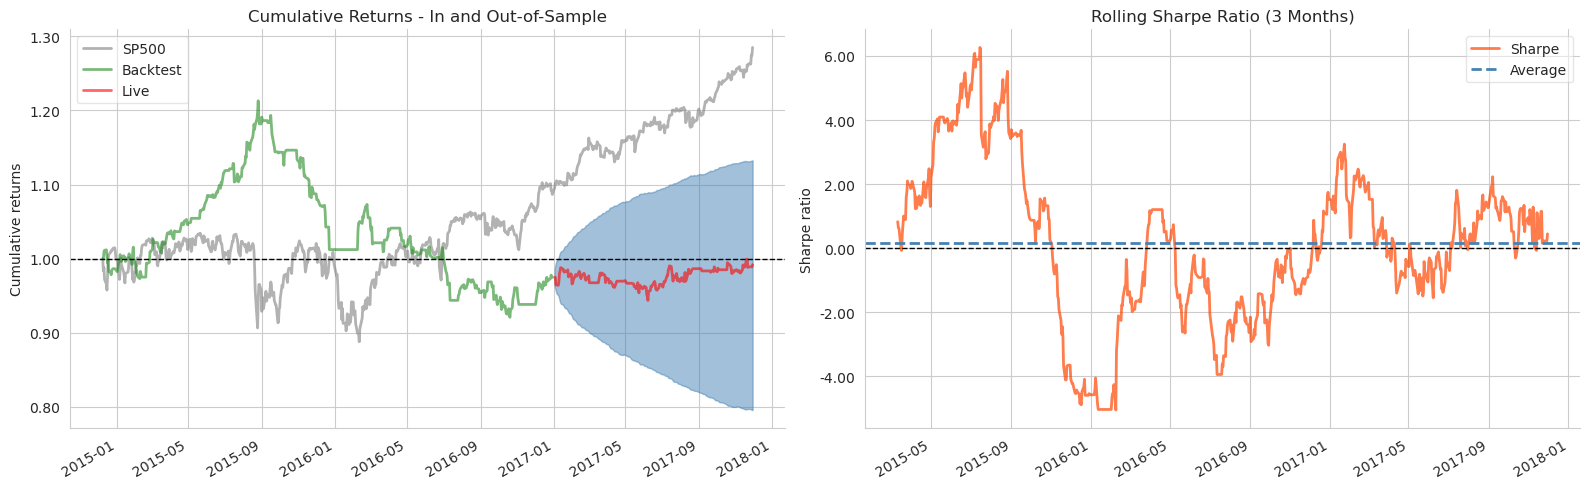

In [6]:
returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(results)
benchmark = web.DataReader('SP500', 'fred', '2014', '2018').squeeze()
benchmark = benchmark.pct_change().tz_localize('UTC')

LIVE_DATE = '2017-01-01'
fig, axes = plt.subplots(ncols=2, figsize=(16, 5))
plot_rolling_returns(returns,
                     factor_returns=benchmark,
                     live_start_date=LIVE_DATE,
                     logy=False,
                     cone_std=2,
                     legend_loc='best',
                     volatility_match=False,
                     cone_function=forecast_cone_bootstrap,
                    ax=axes[0])
plot_rolling_sharpe(returns, ax=axes[1], rolling_window=63)
axes[0].set_title('Cumulative Returns - In and Out-of-Sample')
axes[1].set_title('Rolling Sharpe Ratio (3 Months)')
sns.despine()
fig.tight_layout();

Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,24.09,2015-08-26,2016-10-20,NaT,NaN
1,4.18,2015-01-29,2015-02-09,2015-03-03,24
2,3.32,2014-12-15,2014-12-23,2015-01-29,34
3,2.25,2015-07-15,2015-07-17,2015-08-05,16
4,1.73,2015-03-03,2015-03-17,2015-03-25,17


Stress Events,mean,min,max
Fall2015,-0.04%,-1.95%,1.30%
New Normal,0.00%,-2.92%,2.59%


Top 10 long positions of all time,max
sid,
CRM,35.41%
QCOM,18.43%
TWTR,17.93%
TGT,15.71%
PANW,15.19%
MET,15.06%
INCY,14.91%
TSLA,14.88%
MYL,14.81%


Top 10 short positions of all time,max
sid,
CRM,-30.73%
AMD,-19.68%
MU,-15.94%
SRPT,-15.33%
NFLX,-15.20%
TWTR,-15.19%
ABT,-15.18%
COP,-14.72%
X,-14.49%


Top 10 positions of all time,max
sid,
CRM,35.41%
AMD,19.68%
QCOM,18.43%
TWTR,17.93%
MU,15.94%
TGT,15.71%
SRPT,15.33%
NFLX,15.20%
PANW,15.19%


Summary stats,All trades,Short trades,Long trades
Total number of round_trips,19038.00,9159.00,9879.00
Percent profitable,0.49,0.49,0.50
Winning round_trips,9403.00,4466.00,4937.00
Losing round_trips,9501.00,4622.00,4879.00
Even round_trips,134.00,71.00,63.00


PnL stats,All trades,Short trades,Long trades
Total profit,$-37126.78,$-122016.22,$84889.45
Gross profit,$4191425.77,$2088892.79,$2102532.97
Gross loss,$-4228552.54,$-2210909.02,$-2017643.53
Profit factor,$0.99,$0.94,$1.04
Avg. trade net profit,$-1.95,$-13.32,$8.59
Avg. winning trade,$445.75,$467.73,$425.87
Avg. losing trade,$-445.06,$-478.34,$-413.54
Ratio Avg. Win:Avg. Loss,$1.00,$0.98,$1.03
Largest winning trade,$11070.57,$11070.57,$6145.92
Largest losing trade,$-25762.15,$-19056.24,$-25762.15


Duration stats,All trades,Short trades,Long trades
Avg duration,1 days 11:29:58.487078474,1 days 12:26:11.438039087,1 days 10:37:51.363093430
Median duration,1 days 00:00:00,1 days 00:00:00,1 days 00:00:00
Longest duration,65 days 23:00:00,65 days 23:00:00,5 days 03:00:00
Shortest duration,0 days 00:00:00,0 days 00:00:00,0 days 00:00:00


Return stats,All trades,Short trades,Long trades
Avg returns all round_trips,0.00%,-0.00%,0.00%
Avg returns winning,0.04%,0.04%,0.04%
Avg returns losing,-0.04%,-0.04%,-0.04%
Median returns all round_trips,0.00%,-0.00%,0.00%
Median returns winning,0.02%,0.02%,0.02%
Median returns losing,-0.02%,-0.02%,-0.02%
Largest winning trade,1.02%,0.96%,1.02%
Largest losing trade,-1.98%,-1.98%,-1.30%


Symbol stats,AAL,AAOI,AAPL,ABBV,ABT,ACN,ADBE,ADI,ADP,ADSK,AET,AGN,AIG,ALTR,ALXN,AMAT,AMBA,AMD,AMGN,AMT,AMZN,ANTM,APA,APC,APD,ARNC,ATVI,AVGO,AXP,AZO,BA,BAC,BAX,BBY,BDX,BIDU,BIIB,BK,BMY,BP,BSX,C,CAT,CB,CCE,CCI,CCL,CELG,CHK,CHTR,CI,CL,CMCSA,CMG,CMI,CNC,COF,COL,COP,COST,COTY,CRM,CSCO,CSX,CTL,CTSH,CVS,CVX,CXO,DAL,DE,DFS,DG,DHR,DIS,DISH,DLR,DLTR,DTV,DUK,DVN,EA,EBAY,EFX,EL,EMR,ENDP,EOG,EQIX,EQT,ESRX,EXPE,F,FB,FCX,FDX,FL,FLT,FOXA,FTI,GE,GILD,GM,GOOG,GOOGL,GPN,GS,GWW,HAL,HCA,HD,HES,HON,HPQ,HSY,HTZ,HUM,IBM,ILMN,INCY,INTC,INTU,ISRG,JCI,JNJ,JPM,KHC,KMI,KO,KORS,KR,LB,LDOS,LL,LLY,LMT,LOW,LRCX,LUV,LVS,LYB,M,MA,MAR,MCD,MCHP,MCK,MDLZ,MDT,MET,MGM,MMM,MO,MPC,MRK,MRO,MS,MSFT,MU,MYL,NEE,NEM,NFLX,NKE,NOV,NVDA,NWL,OKE,ORCL,ORLY,OXY,PANW,PCG,PEP,PFE,PG,PM,PNC,PRGO,PSX,PXD,PYPL,QCOM,RAD,RCL,REGN,RF,RIG,SBAC,SBUX,SCHW,SE,SHW,SIG,SLB,SO,SPG,SRPT,STZ,SWKS,SWN,SYF,SYY,T,TAP,TDG,TGT,TJX,TMO,TMUS,TSLA,TSN,TWTR,TXN,UAA,UAL,ULTA,UNH,UNP,UPS,URI,USB,UTX,V,VLO,VMW,VRTX,VRX,VZ,WBA,WDC,WFC,WLL,WMB,WMT,WYNN,X,XOM,YELP,YUM
Avg returns all round_trips,-0.00%,0.01%,-0.00%,0.01%,0.00%,0.03%,-0.01%,-0.01%,-0.02%,0.01%,0.01%,-0.00%,-0.00%,-0.03%,0.03%,-0.03%,-0.03%,-0.00%,0.00%,NaN,0.01%,0.00%,0.01%,0.00%,-0.00%,-0.08%,0.00%,0.01%,0.01%,-0.01%,-0.00%,0.01%,0.02%,0.00%,-0.00%,-0.00%,0.01%,0.03%,0.01%,NaN,NaN,0.00%,0.00%,-0.01%,0.01%,0.06%,0.06%,0.00%,0.02%,0.00%,0.02%,0.00%,-0.02%,-0.00%,0.04%,0.05%,0.03%,0.03%,0.01%,0.01%,0.04%,0.00%,0.01%,-0.01%,NaN,0.06%,-0.01%,-0.01%,0.11%,-0.00%,NaN,NaN,-0.03%,0.02%,-0.00%,-0.02%,-0.00%,-0.01%,-0.07%,-0.04%,0.01%,-0.02%,-0.01%,0.09%,NaN,NaN,NaN,-0.01%,-0.02%,0.00%,-0.02%,-0.02%,-0.01%,0.03%,0.01%,0.01%,0.00%,0.01%,-0.00%,0.02%,-0.02%,-0.01%,0.01%,-0.01%,-0.00%,0.05%,-0.00%,0.10%,-0.01%,-0.05%,-0.01%,-0.03%,0.02%,0.00%,0.07%,-0.02%,-0.02%,-0.00%,NaN,0.01%,-0.01%,-0.00%,-0.11%,-0.00%,-0.01%,0.01%,-0.00%,0.00%,0.00%,0.01%,0.01%,0.02%,-0.02%,0.01%,-0.00%,0.00%,-0.01%,0.01%,-0.01%,-0.00%,-0.01%,-0.00%,-0.01%,0.00%,0.01%,-0.02%,-0.00%,-0.01%,-0.00%,0.00%,-0.02%,-0.00%,-0.01%,0.01%,0.00%,0.01%,0.01%,-0.02%,0.01%,0.00%,0.02%,0.02%,0.00%,-0.01%,0.02%,0.01%,-0.00%,0.00%,-0.00%,0.01%,-0.01%,-0.02%,-0.01%,0.01%,-0.00%,0.00%,-0.00%,0.00%,0.00%,0.00%,0.01%,-0.00%,-0.01%,-0.02%,-0.01%,-0.00%,0.01%,-0.01%,-0.03%,0.00%,-0.01%,0.01%,0.01%,-0.02%,-0.01%,-0.02%,0.03%,-0.00%,-0.01%,-0.01%,0.03%,0.02%,-0.02%,-0.00%,-0.01%,-0.02%,0.01%,-0.00%,0.06%,-0.01%,-0.00%,-0.01%,0.00%,0.01%,0.00%,0.01%,0.02%,-0.00%,-0.00%,-0.01%,0.05%,0.00%,0.00%,0.00%,0.01%,0.01%,0.01%,0.00%,0.00%,0.00%,0.02%,-0.01%,0.00%,0.00%,0.00%,-0.00%,0.00%,-0.01%,-0.04%,-0.02%
Avg returns winning,0.04%,0.05%,0.03%,0.04%,0.03%,0.05%,0.04%,0.00%,0.02%,0.01%,0.05%,0.05%,0.04%,0.02%,0.07%,0.02%,0.07%,0.04%,0.04%,NaN,0.05%,0.04%,0.05%,0.06%,NaN,0.02%,0.05%,0.05%,0.04%,0.03%,0.04%,0.04%,0.07%,0.05%,0.04%,0.04%,0.04%,0.05%,0.03%,NaN,NaN,0.03%,0.03%,0.08%,0.02%,0.06%,0.06%,0.04%,0.06%,0.03%,0.06%,0.02%,0.03%,0.07%,0.12%,0.08%,0.07%,0.13%,0.05%,0.03%,0.05%,0.05%,0.12%,0.08%,NaN,0.18%,0.07%,0.05%,0.26%,0.06%,NaN,NaN,0.08%,0.06%,0.07%,0.00%,0.03%,0.03%,NaN,0.01%,0.06%,0.03%,0.05%,0.14%,NaN,NaN,NaN,0.06%,0.03%,0.03%,0.05%,0.10%,0.08%,0.11%,0.08%,0.07%,0.00%,0.01%,0.04%,0.02%,0.06%,0.04%,0.04%,0.04%,0.03%,0.05%,0.04%,0.10%,0.08%,NaN,0.04%,0.00%,0.05%,0.00%,0.07%,0.00%,0.02%,0.03%,NaN,0.19%,0.07%,NaN,NaN,0.01%,0.06%,0.05%,0.01%,0.04%,0.04%,0.04%,0.04%,0.03%,0.00%,0.04%,0.03%,0.02%,0.02%,0.04%,0.02%,0.04%,0.03%,0.03%,0.03%,0.02%,0.06%,NaN,0.03%,0.03%,0.04%,0.03%,0.05%,0.05%,0.04%,0.02%,0.05%,0.04%,0.05%,0.04%,0.05%,0.03%,0.02%,0.04%,0.03%,0.03%,0.07%,0.03%,0.02%,0.00%,0.04%,0.05%,0.02%,0.04%,0.01%,0.04%,0.03%,0.04%,0.03%,0.06%,0.02%,0.00%,0.05%,0.03%,0.04%,0.02%,0.03%,0.02%,0.03%,0.01%,0.01%,0.04%,0.02%,0.03%,0.08%,0.01%,0.05%,0.04%,0.06%,0.02%,0.02%,0.03%,0.07%,0.08%,NaN,0.03%,0.02%,0.02%,0.05%,0.05%,0.15%,0.00%,0.04%,0.02%,0.04%,0.05%,0.05%,0.03%,0.04%,0.02%,0.04%,0.04%,0.06%,0.04%,0.04%,0.05%,0.05%,0.01%,0.07%,0.03%,0.03%,0.02%,0.04%,0.03%,0.05%,0.04%,0.03%,0.03%,0.05%,0.05%,NaN,0.02%
Avg returns losin

Profitability (PnL / PnL total) per name,
symbol,
TWTR,115.55%
VRX,113.33%
FCX,108.32%
X,75.34%
SBUX,67.00%
CRM,55.41%
AAPL,52.55%
CVX,35.57%
CHK,34.96%


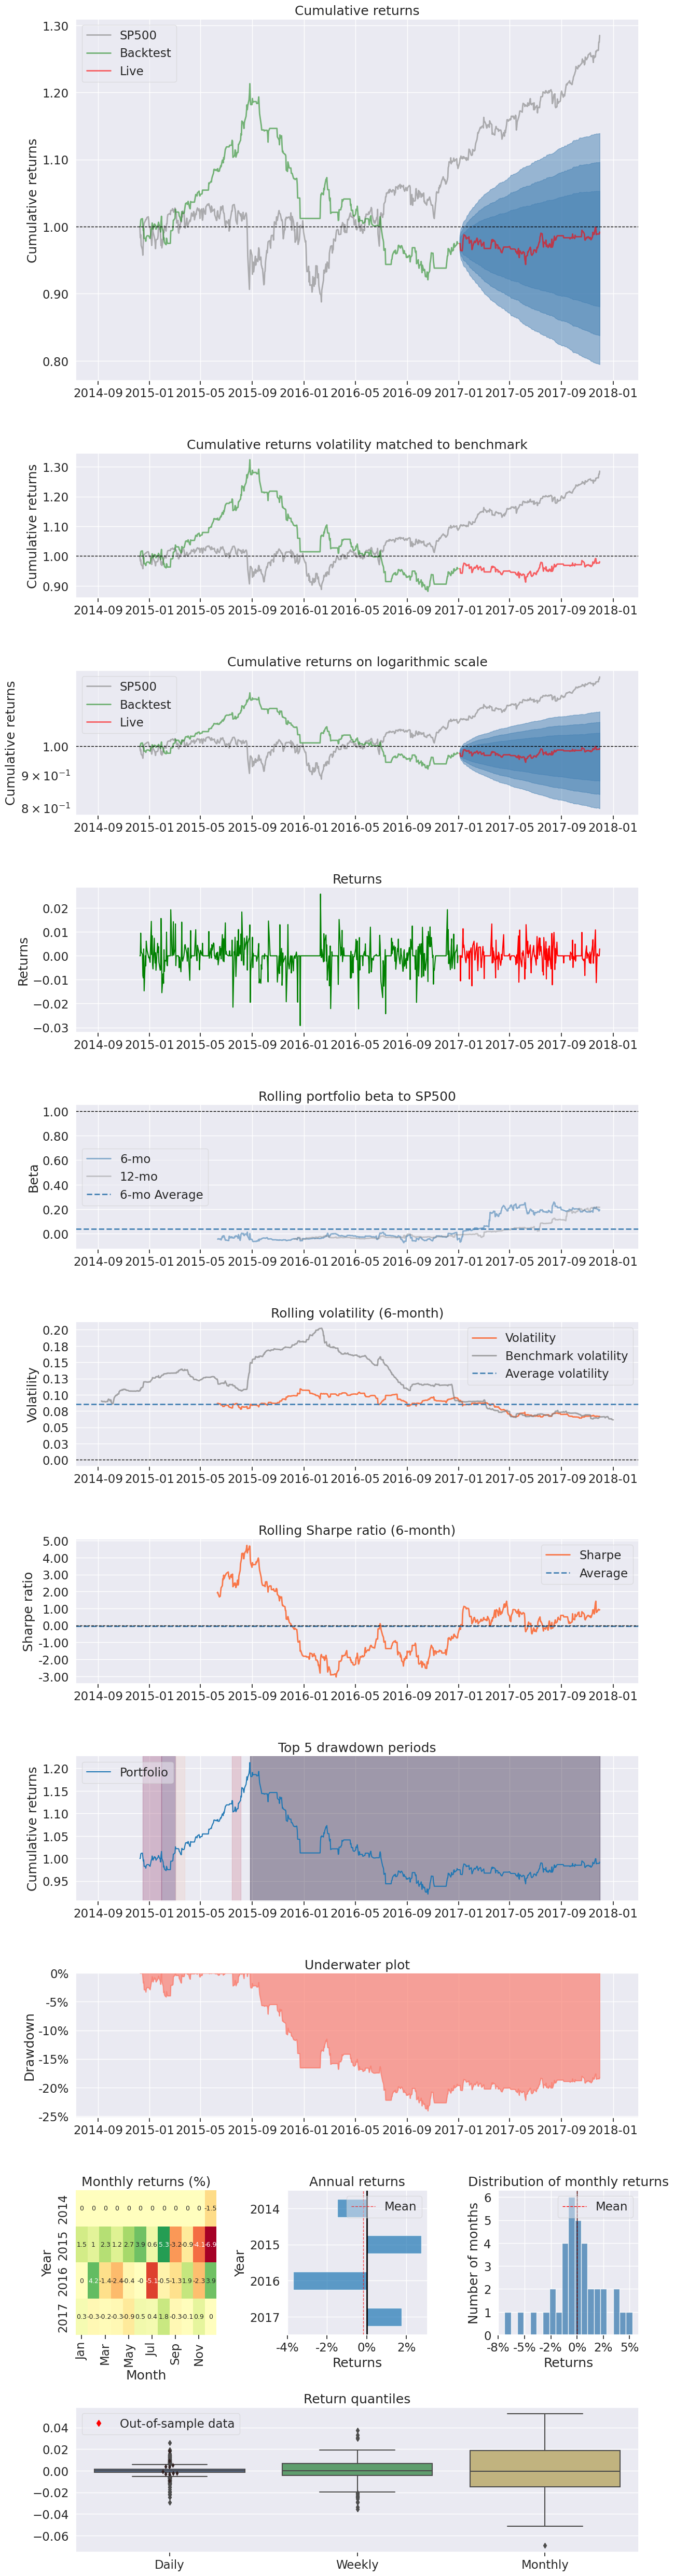

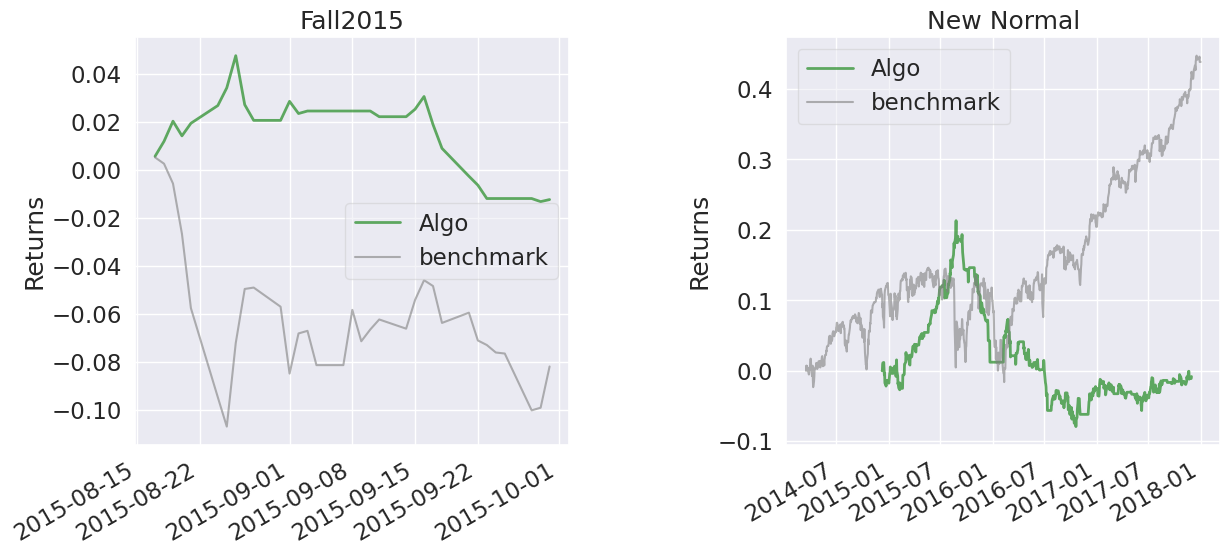

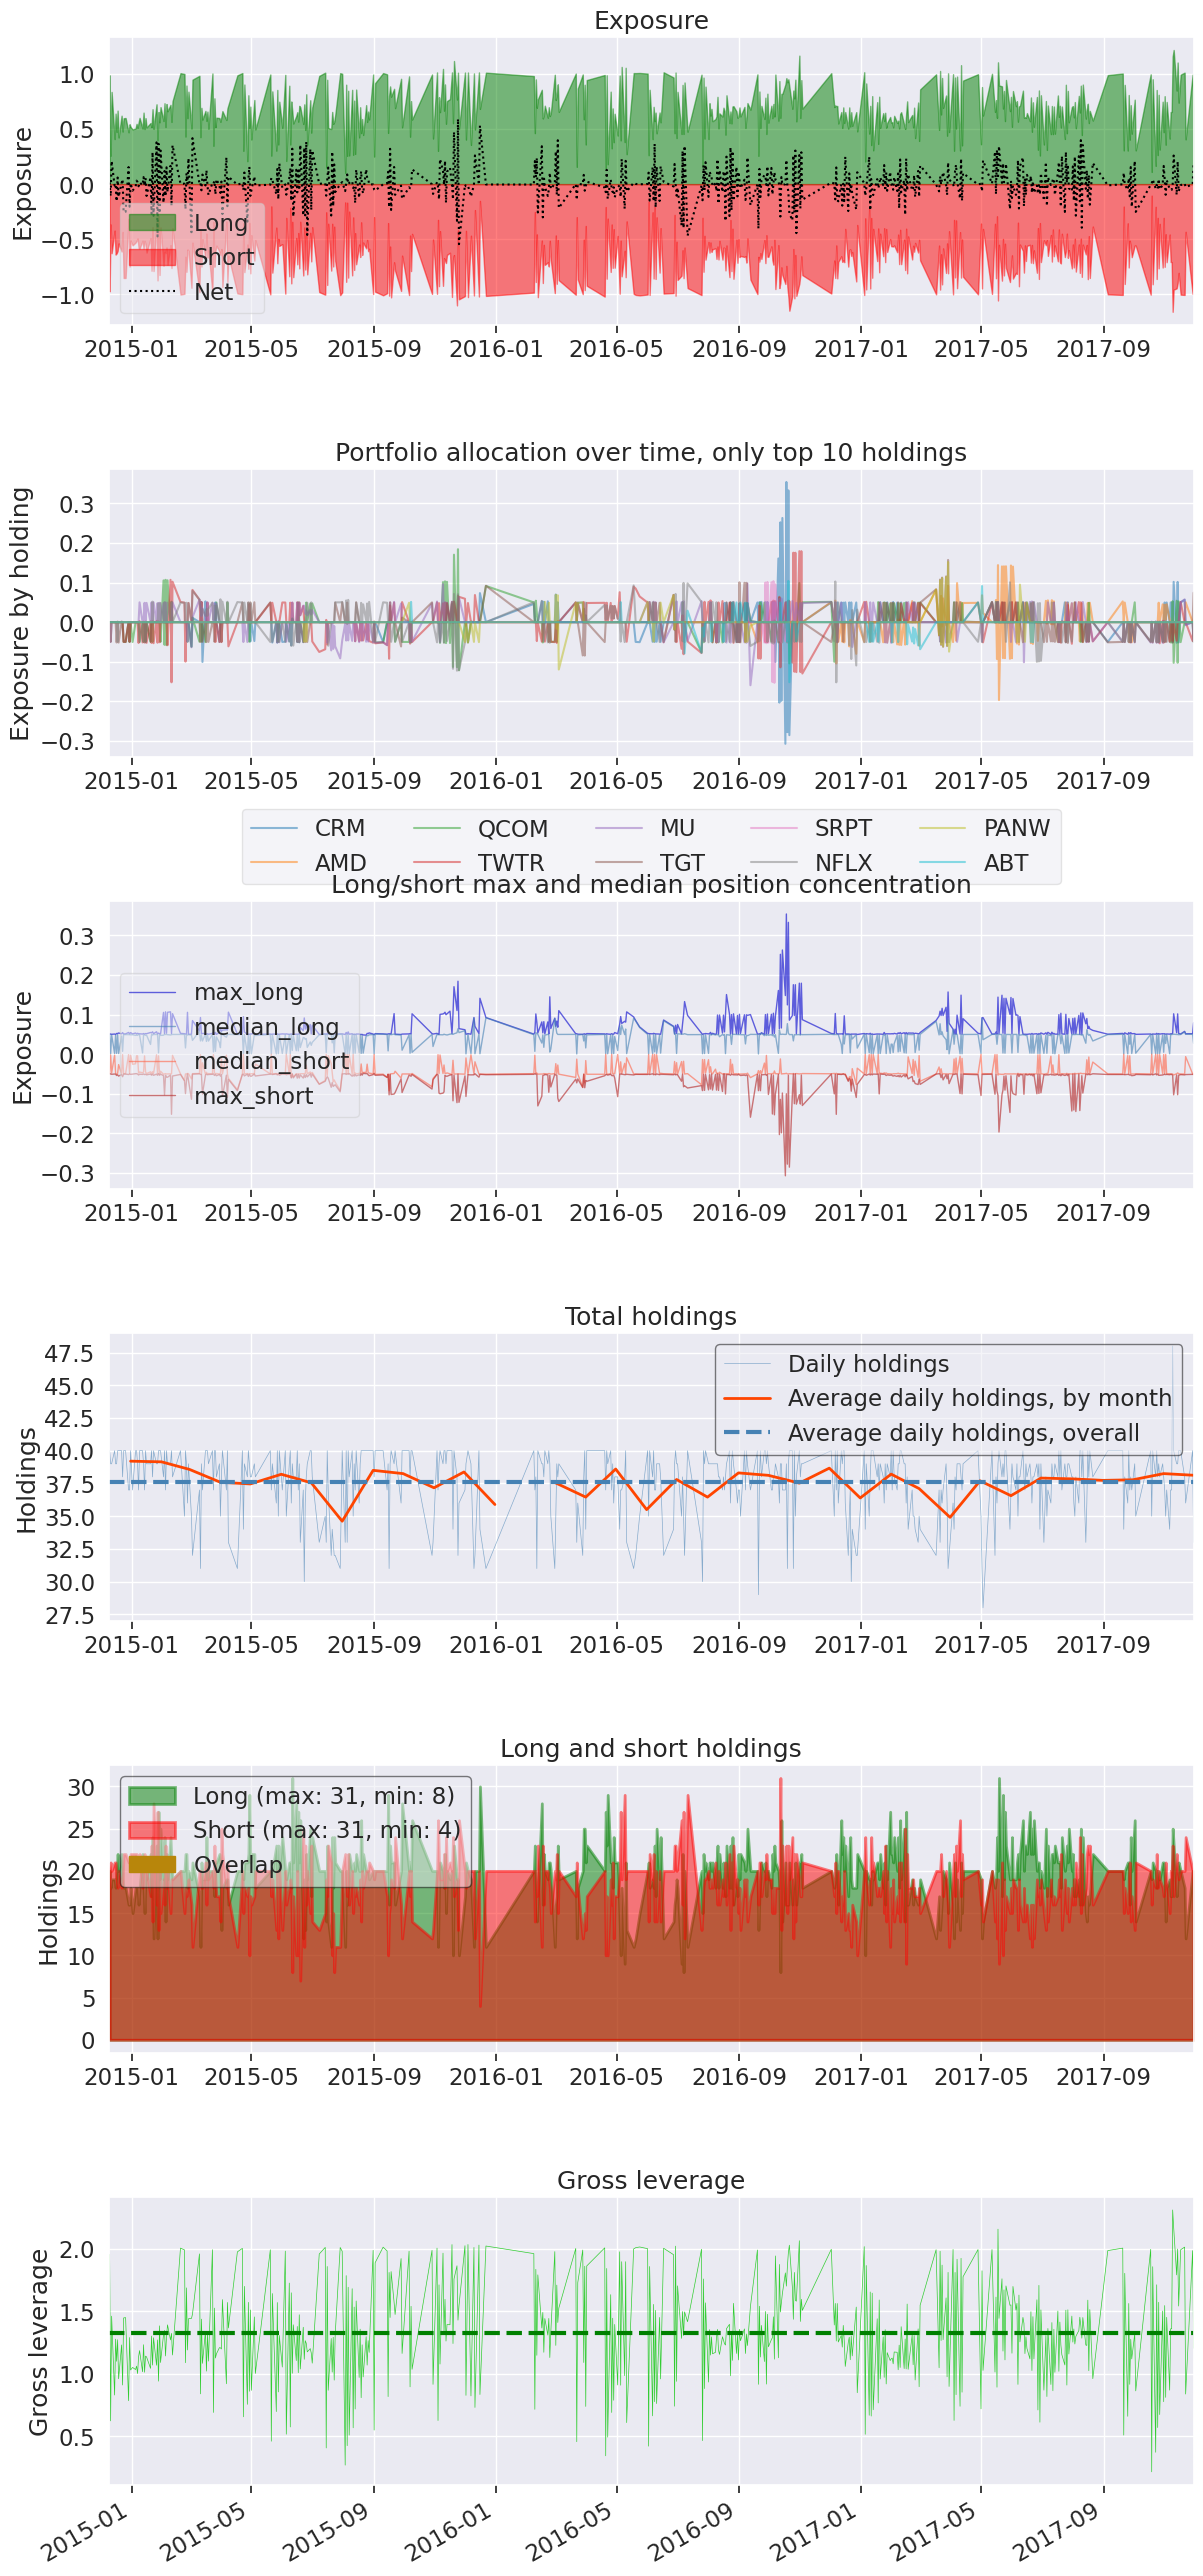

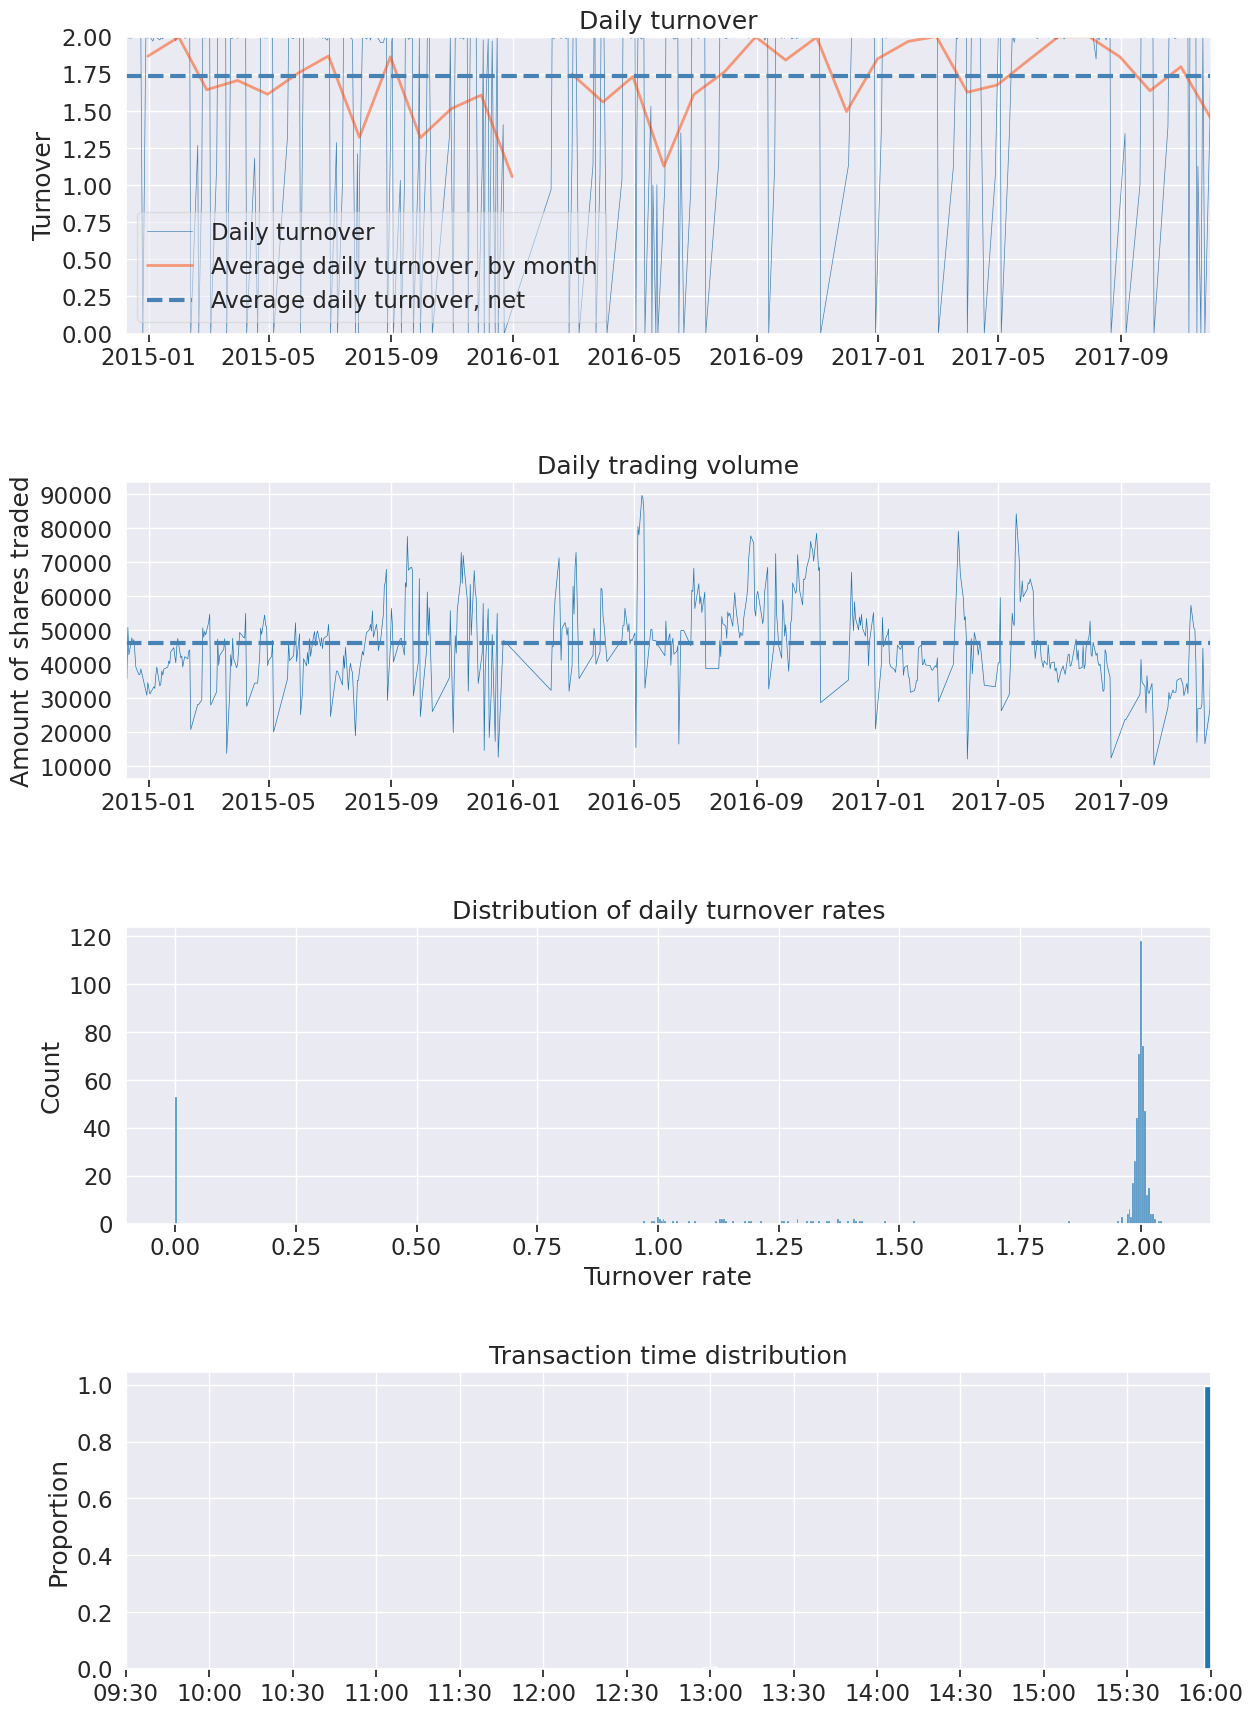

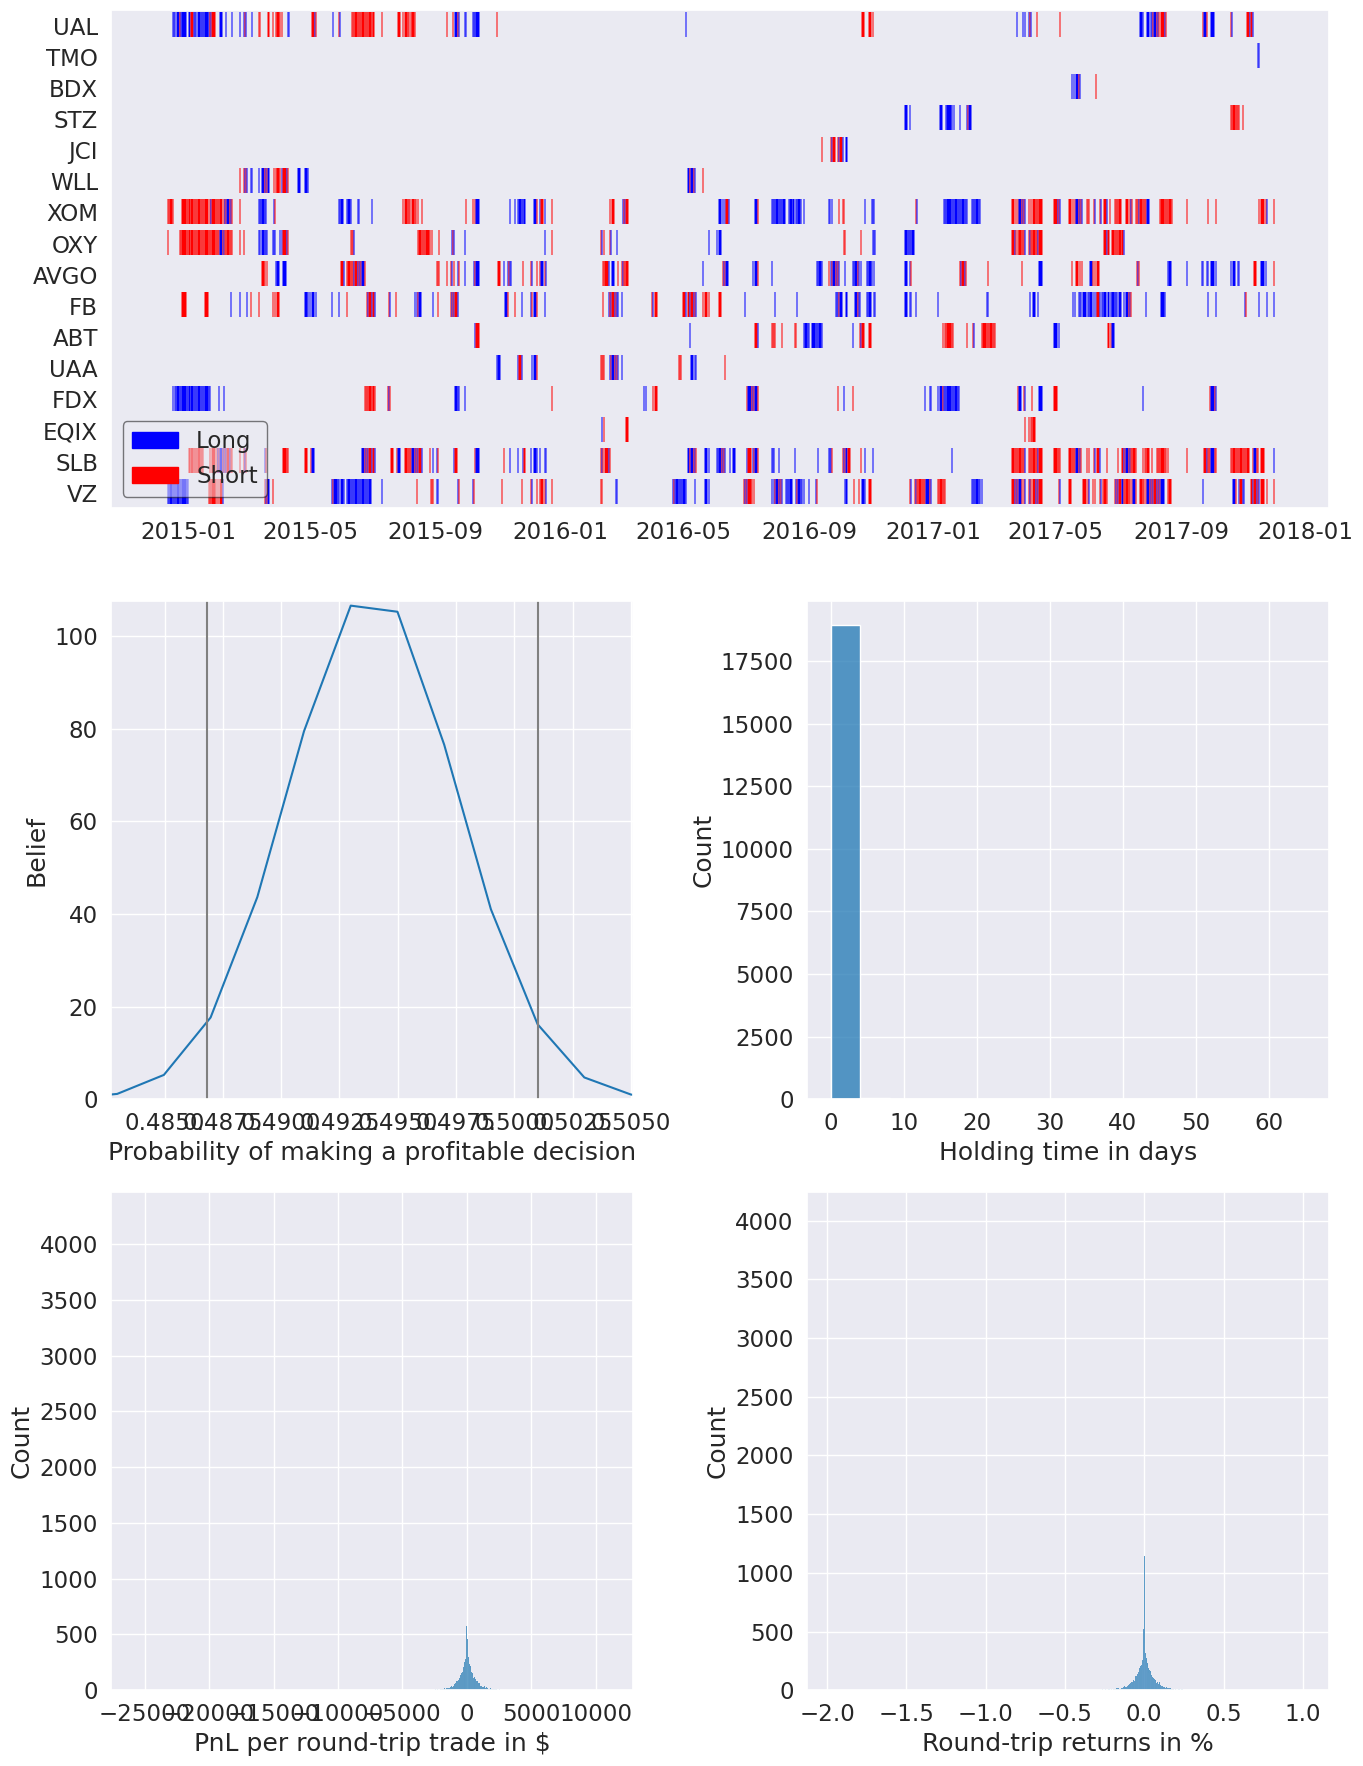

In [7]:
pf.create_full_tear_sheet(returns, 
                          positions=positions, 
                          transactions=transactions,
                          benchmark_rets=benchmark,
                          live_start_date=LIVE_DATE, 
                          round_trips=True)